# 1. Initial Classification - Clustering

While the baby products dataset has a main_category field, it proves lacking. Many of the categories lack a detailed description, such as 'Baby', or have categories that do not prove meaningful in the context of baby products, such as Amazon Home or Amazon Fashion.

As a result, we will use multiple clustering techniques to classify these products into more meaningful categories. In particular, we will use unsupervised learning techniques, creating clusters both via K-Means and via HDBSCAN.

In each instance, we will utilize BERT for preprocessing. After evaluating several models during the initial exploratory analysis phase, `all-MiniLM-L6-v2` provides the best balance in terms of speed and classification. We will use this to create the initial embeddings.

For the dimension reduction, we will  adjust this depending on the final clustering method. For the K-Means clustering method, we will use PCA. For the HDBSCAN method, we will use UMAP and specifically cosine distancing.

Finally, we will perform the actual clustering via either K-Means or HDBSCAN. The former is faster, but has a relatively low silhouette score, whereas the larger has a relatively large DBCV score, but breaks the data into a large number of clusters that, on their own, are too granually and will require additional methods for grouping.

The goal of this program will be to produce the resulting analysis and figures from these two clustering methods, as well as output Excel files for further review.

## Data Load and Preprocessing

Load the initial dataset for classification. Run preprocessing to clean up empty or meaningless category values which will serve as the basis for our clustering. Also remove stopwords that do not provide meaningful information on the product, such as "Baby" or "Product".

In [1]:
# Load necessary libraries for pre-processing and clustering

# Pre-processing
import pandas as pd # Used throughout to make text processing and data processing easier
import re # Provides regular expression (regex) support

# Embeddings
from sentence_transformers import SentenceTransformer

# PCA and KMeans Clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# UMAP and HDBSCAN Clustering
from umap import UMAP
from sklearn.preprocessing import normalize
import hdbscan
from hdbscan.validity import validity_index
import numpy as np

# Cluster Visualization
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

/Users/adamng/miniconda3/envs/babyml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the file of baby products that was extracted from the Julian McAuley dataset of Amazon reviews
file_path = "/Volumes/Samsung1TB/programming/data-science/baby-product-dashboard/raw-data/baby_product_names.csv"
names = pd.read_csv(file_path)

/var/folders/31/nfkt6j8n27lbjf69r6vs1jpc0000gn/T/ipykernel_22744/3804158108.py:3: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  names = pd.read_csv(file_path)


In [3]:
# Prepare the categories column for KMeans clustering. Specifically, if it contains meaningless text, such as [], 
# replace this with more meaningful text 

# Redefine df 
df = names

# Create a function to replace missing or '[]' values in the categories_clean column
def cat_replacement(row):
    for col in ['categories', 'title', 'description', 'details']:
        val = str(row[col]).strip()
        if val not in ['', '[]']:
            return val
    return '' # fallback if all are blank

# Call the function
df['category_select'] = df.apply(cat_replacement, axis = 1)

# Make sure the categories column is a string. Fill missing values first and convert all values to lowercase
df['categories_clean'] = df['category_select'].astype('string').fillna('').str.lower()

In [4]:
# Develop process for removing stopwords and special characters to improve embeddings

# Define domain specific stopwords: 
stopwords = {
    'baby', 'product', 'products', 'infant', 'newborn', 'brand', 'pack', 'size',
    'new'
}

# Function to clean special characters and domain specific stopwords
def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Remove square brackets, squiggly brackets, colon, semi-colon, and comma
    text = re.sub(r'[\[\]\{\}\:\;\,]', '', text)

    # Remove quotes
    text = text.replace("'", "").replace('"', '')

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)

    # Lowercase
    text = text.lower()

    # Split words (may not be necessary anymore now that we're not using stopwords )
    words = text.split()
    filtered_words = [word for word in words if word not in stopwords]

    return ' '.join(filtered_words).strip()

# Call the above function to remove special characters and whitespace from the categories_clean field
df['categories_clean'] = df['categories_clean'].apply(clean_text)

In [5]:
# Confirm that none of the category values are blank or []
df[df['categories_clean'].isin(["", "[]"])]

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author,category_select,categories_clean


In [9]:
# Check the first few observations of the resulting dataframe to ensure it is ready for clustering
df.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author,category_select,categories_clean
0,Baby,"Chicco Viaro Travel System, Teak",4.6,125,['Aluminum' 'Imported'\n 'Convenient one-hand ...,['Product Description'\n 'For ultimate conveni...,NaN,{'hi_res': array(['https://m.media-amazon.com/...,"{'title': array(['Viaro Demo Video', 'Chicco V...",Chicco,['Baby Products' 'Strollers & Accessories' 'St...,"{""Product Dimensions"": ""38 x 41.25 x 25.5 inch...",B01C4319LO,NaN,NaN,NaN,['Baby Products' 'Strollers & Accessories' 'St...,strollers & accessories strollers travel systems
1,AMAZON FASHION,Kisbaby Four Layers Muslin Lightweight Unisex ...,5.0,2,"['95% Cotton, 4 Layer Muslin, Hand Wash in Col...",['You can choose bigger size If you confuse ab...,NaN,{'hi_res': array(['https://m.media-amazon.com/...,"{'title': array([], dtype=object), 'url': arra...",Kisbaby,['Baby Products' 'Nursery' 'Bedding' 'Blankets...,"{""Material"": ""Muslin"", ""Color"": ""Blue Star"", ""...",B07FM4MJJP,NaN,NaN,NaN,['Baby Products' 'Nursery' 'Bedding' 'Blankets...,nursery bedding blankets & swaddling wearable ...
2,Baby,EZTOTZ Meals with Milton - USA Made Toddler & ...,4.4,37,['WHAT IS MILTON?: Milton is the fun way for y...,[],22.99,{'hi_res': array(['https://m.media-amazon.com/...,"{'title': array([], dtype=object), 'url': arra...",EZTOTZ,[],"{""Package Dimensions"": ""6.3 x 5 x 4.76 inches""...",B08WCG372G,NaN,NaN,NaN,EZTOTZ Meals with Milton - USA Made Toddler & ...,eztotz meals with milton - usa made toddler & ...
3,Baby,Nuby iMonster Toddler Bowl,4.4,52,['Makes feeding fun for baby and easier for pa...,['When babies begin to show interest in feedin...,NaN,{'hi_res': array(['https://m.media-amazon.com/...,"{'title': array([], dtype=object), 'url': arra...",Nuby,['Baby Products' 'Feeding' 'Solid Feeding' 'Di...,"{""Product Dimensions"": ""2.75 x 5 x 7.5 inches""...",B0083SXABC,NaN,NaN,NaN,['Baby Products' 'Feeding' 'Solid Feeding' 'Di...,feeding solid feeding dishes
4,Amazon Home,mDesign Slim Storage Organizer Container Bin w...,4.5,235,['SMART STORAGE: This large capacity slim bin ...,"[""The mDesign clear storage bins for kids supp...",NaN,{'hi_res': array(['https://m.media-amazon.com/...,"{'title': array([], dtype=object), 'url': arra...",mDesign,['Baby Products' 'Nursery' 'Furniture' 'Storag...,"{""Product Dimensions"": ""14.62 x 4 x 4 inches"",...",B07N8GRHHK,NaN,NaN,NaN,['Baby Products' 'Nursery' 'Furniture' 'Storag...,nursery furniture storage & organization stora...


## K-Means Clustering

We will run the process for clustering via K-Means. We will also perform the process of elbowing to see at what point the clusters are most efficient. Once we identify the point of the most efficient clusters, we will output the resulting dataset as an Excel file.

In [6]:
# Create a field within our dataset named text that we will use for the embeddings
df_kmeans = df.dropna(subset = 'categories_clean') # This shouldn't do anything, since we know there are no NaN from earlier
df_kmeans['text'] = df['categories_clean'].astype(str)

# Load and apply the model to the dataframe for embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df_kmeans['text'].tolist(), show_progress_bar = True)

Batches: 100%|██████████| 6804/6804 [00:38<00:00, 176.51it/s]


In [34]:
# Reduce to 50 dimensions for better KMeans performance
pca = PCA(n_components = 50)
reduced_embeddings = pca.fit_transform(embeddings)

In [35]:
# Perform elbowing - identify what number of clusters provides the most meaningful results
inertias = []
k_range = range(10, 51) 

for k in k_range:  # Try a range of values
    km = KMeans(n_clusters = k, random_state = 42, n_init = 10)
    labels = km.fit_predict(reduced_embeddings)  # or raw embeddings
    score = silhouette_score(reduced_embeddings, labels)
    inertias.append(km.inertia_)
    print(f"k = {k} → Silhouette Score: {score:.3f}")

k = 10 → Silhouette Score: 0.304
k = 11 → Silhouette Score: 0.325
k = 12 → Silhouette Score: 0.318
k = 13 → Silhouette Score: 0.350
k = 14 → Silhouette Score: 0.351
k = 15 → Silhouette Score: 0.364
k = 16 → Silhouette Score: 0.375
k = 17 → Silhouette Score: 0.379
k = 18 → Silhouette Score: 0.395
k = 19 → Silhouette Score: 0.395
k = 20 → Silhouette Score: 0.414
k = 21 → Silhouette Score: 0.426
k = 22 → Silhouette Score: 0.435
k = 23 → Silhouette Score: 0.435
k = 24 → Silhouette Score: 0.449
k = 25 → Silhouette Score: 0.461
k = 26 → Silhouette Score: 0.463
k = 27 → Silhouette Score: 0.465
k = 28 → Silhouette Score: 0.475
k = 29 → Silhouette Score: 0.482
k = 30 → Silhouette Score: 0.486
k = 31 → Silhouette Score: 0.494
k = 32 → Silhouette Score: 0.504
k = 33 → Silhouette Score: 0.509
k = 34 → Silhouette Score: 0.516
k = 35 → Silhouette Score: 0.517
k = 36 → Silhouette Score: 0.512
k = 37 → Silhouette Score: 0.506
k = 38 → Silhouette Score: 0.523
k = 39 → Silhouette Score: 0.524
k = 40 → S

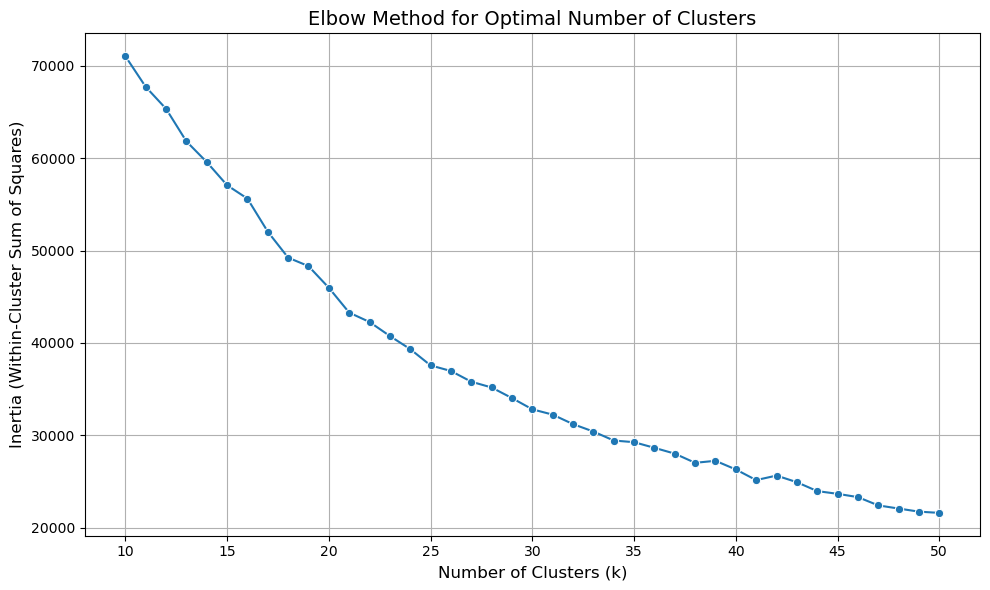

In [36]:
# Plot the elbow curve
# Prepare data for seaborn
elbow_df = pd.DataFrame({
    'k': list(k_range),
    'inertia': inertias
})

# Plot using seaborn
plt.figure(figsize = (10, 6))
sns.lineplot(data = elbow_df, x = 'k', y = 'inertia', marker = 'o')
plt.title('Elbow Method for Optimal Number of Clusters', fontsize = 14)
plt.xlabel('Number of Clusters (k)', fontsize = 12)
plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize = 12)
plt.grid(True)
plt.xticks(list(k_range)[::5])  # Show every 5th tick for clarity
plt.tight_layout()
plt.show()

In [39]:
# Calculate the elbow point using the first and second derivatives
# Compute first and second derivatives
first_derivative = np.diff(inertias)
second_derivative = np.diff(first_derivative)

elbow_candidates = second_derivative
for idx, val in enumerate(elbow_candidates):
    k = k_range[idx + 2]
    print(f"Second derivative at k={k}: {val:.4f}")

Second derivative at k=12: 943.6289
Second derivative at k=13: -1150.6836
Second derivative at k=14: 1287.0273
Second derivative at k=15: -270.2969
Second derivative at k=16: 1061.7031
Second derivative at k=17: -2133.5664
Second derivative at k=18: 771.8242
Second derivative at k=19: 1894.0703
Second derivative at k=20: -1426.8320
Second derivative at k=21: -346.2695
Second derivative at k=22: 1674.5430
Second derivative at k=23: -504.3086
Second derivative at k=24: 99.5547
Second derivative at k=25: -342.1367
Second derivative at k=26: 1155.5430
Second derivative at k=27: -554.1719
Second derivative at k=28: 535.4258
Second derivative at k=29: -522.8008
Second derivative at k=30: -68.6484
Second derivative at k=31: 641.2559
Second derivative at k=32: -452.3477
Second derivative at k=33: 225.2871
Second derivative at k=34: -169.4297
Second derivative at k=35: 789.7109
Second derivative at k=36: -428.4473
Second derivative at k=37: -19.2539
Second derivative at k=38: -364.8535
Second d

Using the second derivative to measure the rate of difference between the clusters (or curve bends), we can identify the elbow points at K = 19 and K =42 


We will output two options from KMeans - 19 clusters and 42. The former performs worse but is easier to analyze while the latter has a better silhouette score but is more complicated to review.

In [16]:
# KMeans at 20 clusters
df_kmeans_20 = df_kmeans

kmeans = KMeans(n_clusters = 20, random_state = 42, n_init = 10) # n_init is the number of times KMeans will run with different centroid seeds
df_kmeans_20['cluster'] = kmeans.fit_predict(reduced_embeddings)

In [ ]:
# Print the silhouette score for 20 clusters
score_20 = silhouette_score(reduced_embeddings, df_kmeans_20['cluster'])
print(f"Silhouette Score for 20 clusters: {score_20:.2f}")

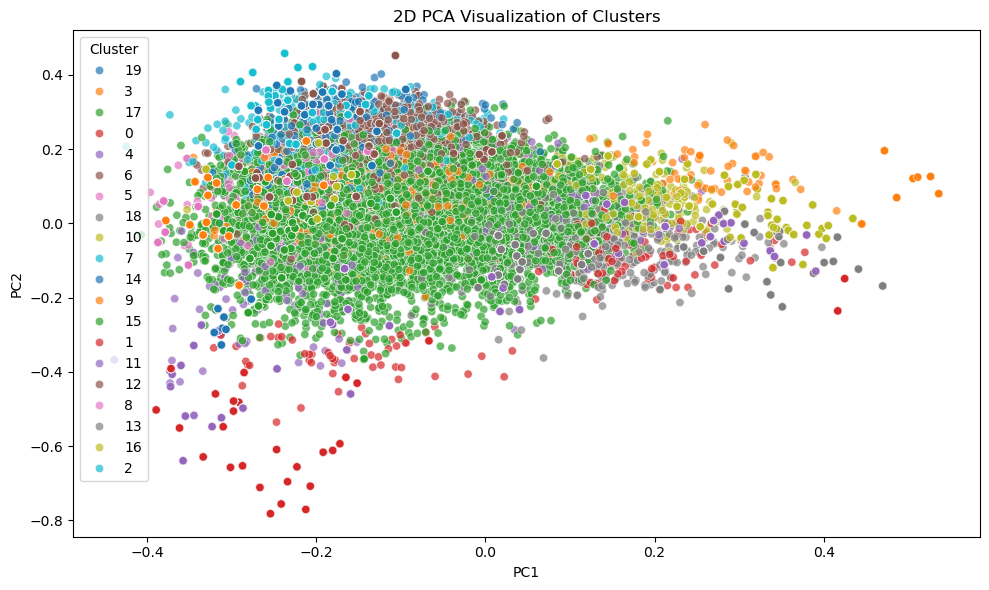

In [28]:
# Plot the clusters
# Reduce to 2D for visualization
pca_2d = PCA(n_components=2)
reduced_2d = pca_2d.fit_transform(embeddings)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'PC1': reduced_2d[:, 0],
    'PC2': reduced_2d[:, 1],
    'cluster': df_kmeans_20['cluster'].astype(str)  # for coloring
})

# Plot with Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='cluster', palette='tab10', alpha=0.7)
plt.title("2D PCA Visualization of Clusters")
plt.legend(title='Cluster', )
plt.tight_layout()
plt.show()

In [27]:
cluster_sort = sorted(df_kmeans_20['cluster'].unique())
print(cluster_sort)

[np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19)]


In [29]:
# KMeans at 50 clusters
df_kmeans_50 = df_kmeans

kmeans = KMeans(n_clusters = 50, random_state = 42, n_init = 10) # n_init is the number of times KMeans will run with different centroid seeds
df_kmeans_50['cluster'] = kmeans.fit_predict(reduced_embeddings)

In [ ]:
# Print the silhouette score for 50 clusters
score_50 = silhouette_score(reduced_embeddings, df_kmeans_50['cluster'])
print(f"Silhouette Score for 50 Clusters: {score_50:.2f}")

Silhouette Score for 20 clusters: 0.57
 Silhouette Score for 50 Clusters: 0.57


/var/folders/31/nfkt6j8n27lbjf69r6vs1jpc0000gn/T/ipykernel_22744/653380289.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


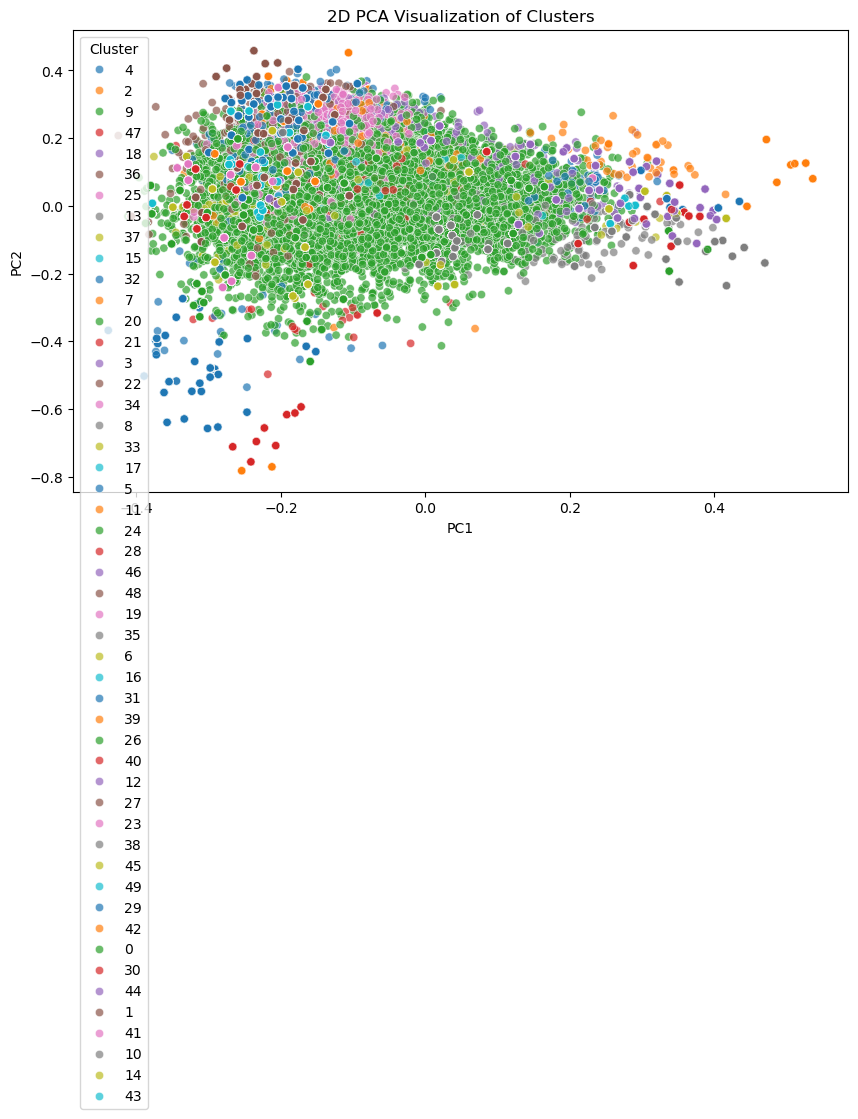

In [30]:
# Plot the clusters
# Reduce to 2D for visualization
pca_2d = PCA(n_components=2)
reduced_2d = pca_2d.fit_transform(embeddings)

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'PC1': reduced_2d[:, 0],
    'PC2': reduced_2d[:, 1],
    'cluster': df_kmeans_50['cluster'].astype(str)  # for coloring
})

# Plot with Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='cluster', palette='tab10', alpha=0.7)
plt.title("2D PCA Visualization of Clusters")
plt.legend(title='Cluster', )
plt.tight_layout()
plt.show()

In [33]:
# Output the two clustered datasets into Excel files
df_kmeans_20.to_excel("/Volumes/Samsung1TB/programming/data-science/baby-product-dashboard/clustered-data/kmeans.xlsx", sheet_name = "Cluster = 20")
df_kmeans_50.to_excel("/Volumes/Samsung1TB/programming/data-science/baby-product-dashboard/clustered-data/kmeans.xlsx", sheet_name = "Cluster = 50")


# HDBSCAN Clustering

We will now utilize UMAP for the dimension reduction and HDBSCAN for the clustering.

In [ ]:
# HDBSCAN Clustering